## Modeling Prostate Cancer Progression

In [1]:
import pandas as pd
import numpy as np
import math


from math import *
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime
from tqdm import tqdm

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.impute import SimpleImputer
import random
import seaborn as sns

import optuna
from optuna.integration import XGBoostPruningCallback

import re

# Utils

We keep track of all the functions used later in this notebook

In [3]:
''' We use this function to only keep the patients that have more than l PSA values (e.g. if we want to use 
3 past PSA values to predict the 4th, we need to keep patients that have 4 or more recorded PSA values '''

def filter_length(df, l):
    return df.groupby('EMPI').filter(lambda x : len(x)>l)

In [4]:
''' Given our lab values dataset and a sequence length, we define a function that allows us to extract the 
PSA sequences as rows along with the rest of the useful corresponding data (BMI, MRI, race, comorbidity scores, etc)
using the sliding window method explained in our report '''

def window(df, l, rate=True, report=True, comorb=True, race=True):
    
    df_x = pd.DataFrame()
    Y = []
    
    idx_comorb = df.columns.get_loc("mi_agg")
    comorb_names = df.columns[idx_comorb::]
        
    race_names = ["Asian", "Black", "Hispanic", "Unknown/other", "White"]
    
    iterator = 0
    
    for patient_id in df.EMPI.unique():

        subset = df[df["EMPI"]==patient_id].sort_values(by=["delta"])
        psa_seq = subset.PSA
        delta_seq = subset.delta
        
        for i in range(l-1,len(subset)-1):
            
            X = []
            Y.append(psa_seq.iloc[i+1])
            
            X.append(patient_id)
            
            for j in range(i-(l-1),i+1):
                
                if rate == True:
                    
                    if j ==(i-(l-1)):
                        X.append(psa_seq.iloc[j])
                    else:
                        if (delta_seq.iloc[j]-delta_seq.iloc[j-i]) > 0:
                            X.append((psa_seq.iloc[j]-psa_seq.iloc[j-1])/(delta_seq.iloc[j]-delta_seq.iloc[j-i]))
                        else:
                            X.append((psa_seq.iloc[j]-psa_seq.iloc[j-1]))
                    
    
                    
                else:
                    
                    X.append(psa_seq.iloc[j])
                    X.append(delta_seq.iloc[j])
                    
                X.append(subset["bmi"].iloc[j])
                
            X.append(delta_seq.iloc[i+1])    
            X.append(subset["age_diagnosis"].iloc[i+1])
            
            if race:
                
                for race in race_names:
                    X.append(subset[race].iloc[i])
            
            if comorb:

                for comor in comorb_names:
                    X.append(subset[comor].iloc[i])
            
            #X.append(subset["race_cat"].iloc[i])
            
            if report:
                X.append(subset["report"].iloc[i])
            
            df_x[iterator] = X
            
            iterator += 1

    return df_x.T, Y

In [5]:
''' We use the previously defined functions to split our dataset into train and test '''

def random_split(df, split_ratio, l=3, seed=10, rate=True, report=True, comorb=True, race=True):
    
    permutation = np.random.RandomState(seed=seed).permutation(merged['EMPI'].unique())
    training_idx, test_idx = permutation[:floor(split_ratio*len(permutation))], permutation[floor(split_ratio*len(permutation)):]

    X_train, y_train = window(df[df['EMPI'].isin(training_idx)], l, rate=rate, report=report, comorb=comorb, race=race)
    X_test, y_test = window(df[df['EMPI'].isin(test_idx)], l, rate=rate, report=report, comorb=comorb, race=race)
    
    return X_train, y_train, X_test, y_test

In [6]:
''' We define a vocabulary and use it to clean our MRI reports in order to run a meaningful Bag of Words'''

def get_notes(pat):
    corpus = []
    for idx in pat.index:
        
        note = pat.loc[idx][len(pat.columns) - 1]
        note = re.sub(r'[0-9]+', '', note)
        note = note.replace("\n", '')
        note = note.replace("\r", '')
        note = note.replace("Exam Number:", "")
        note = note.replace("Report Status:  FinalType:  MRIProstateWWODate/Time:  // :Exam Code:  MRIPROWWOOrdering Provider: ", "")
        note = note.replace("[report_end", "")
        note = note.replace("/", "")
        note = note.strip()
        corpus.append(note)
    return corpus

In [2]:
## Loading the dataset

merged = pd.read_csv("prostate_df.csv")

# Visualisation

Text(0.5, 1.0, 'PSA progression over time of a patient under surveillance from 2006 to 2010')

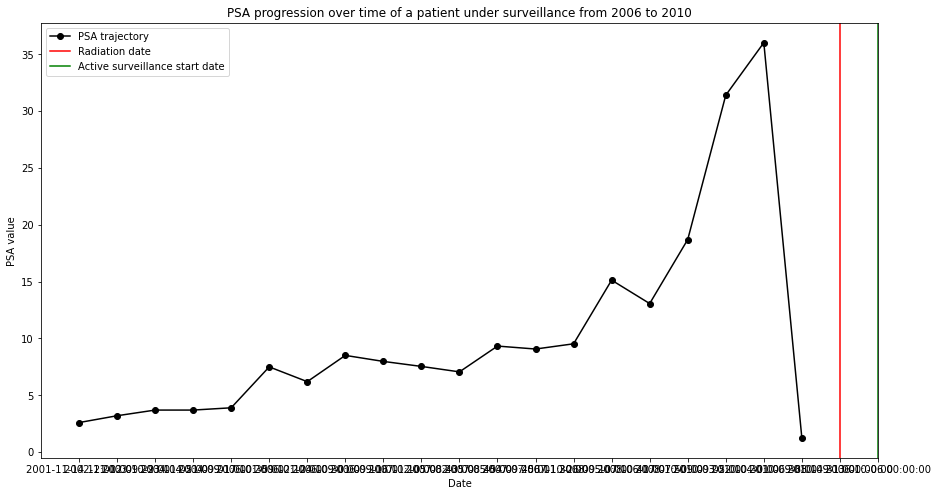

In [16]:
plt.figure(figsize=(15, 8))
example = merged[merged.EMPI == 100035472].sort_values("time_lab_result")
plt.plot(example.time_lab_result[6::], example.PSA[6::], label="PSA trajectory", color="black", marker="o")
plt.axvline(x=example.rdtdate_first.iloc[0], color="red", label="Radiation date")
plt.axvline(x=example.date_firstcancerbx.iloc[0], color="green", label="Active surveillance start date")
plt.legend()
plt.xlabel("Date")
plt.ylabel("PSA value")
plt.title("PSA progression over time of a patient under surveillance from 2006 to 2010")

(0.0, 100.0)

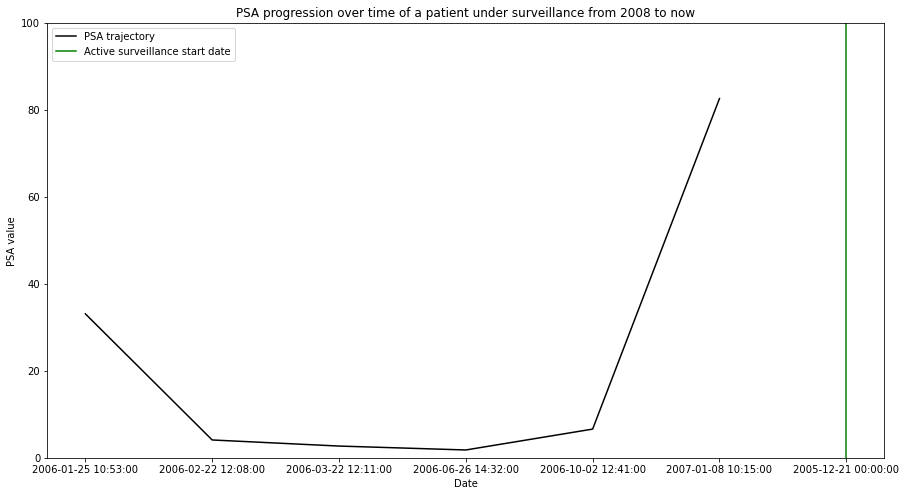

In [17]:
plt.figure(figsize=(15, 8))
example = merged[merged.EMPI == 103664195].sort_values("time_lab_result")
#example = merged[merged.EMPI == 100003030].sort_values("time_lab_result")
plt.plot(example.time_lab_result, example.PSA, label="PSA trajectory", color="black")
#plt.axvline(x=example.rdtdate_first.iloc[0], color="red", label="Radiation date")
plt.axvline(x=example.date_firstcancerbx.iloc[0], color="green", label="Active surveillance start date")
#plt.axvline(x=example.rdtdate_first.iloc[0], color="red", label="Radiation date")
plt.legend()
plt.xlabel("Date")
plt.ylabel("PSA value")
plt.title("PSA progression over time of a patient under surveillance from 2008 to now")
plt.ylim((0, 100))

(0.0, 80.0)

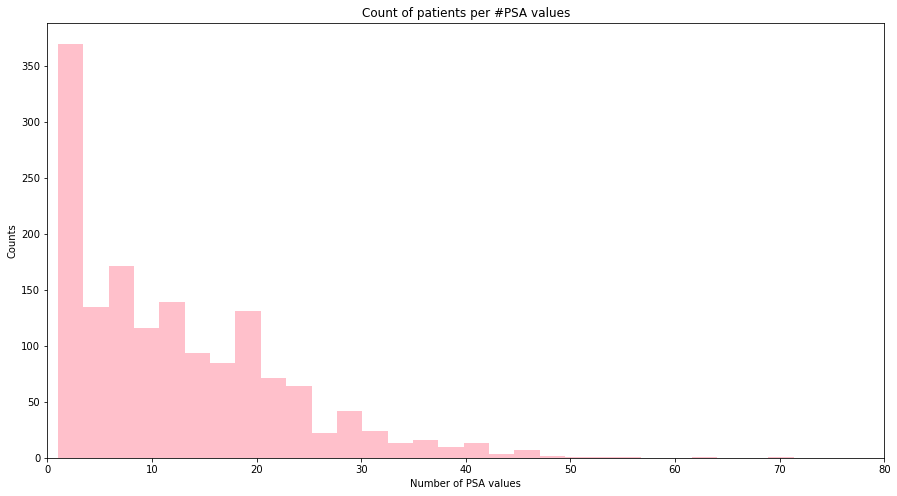

In [11]:
plt.figure(figsize=(15, 8))
plt.hist(merged["EMPI"].value_counts(), bins=40, color="pink")
plt.xlabel("Number of PSA values")
plt.ylabel("Counts")
plt.title("Count of patients per #PSA values")
plt.xlim((0, 80))

(0.0, 24.0)

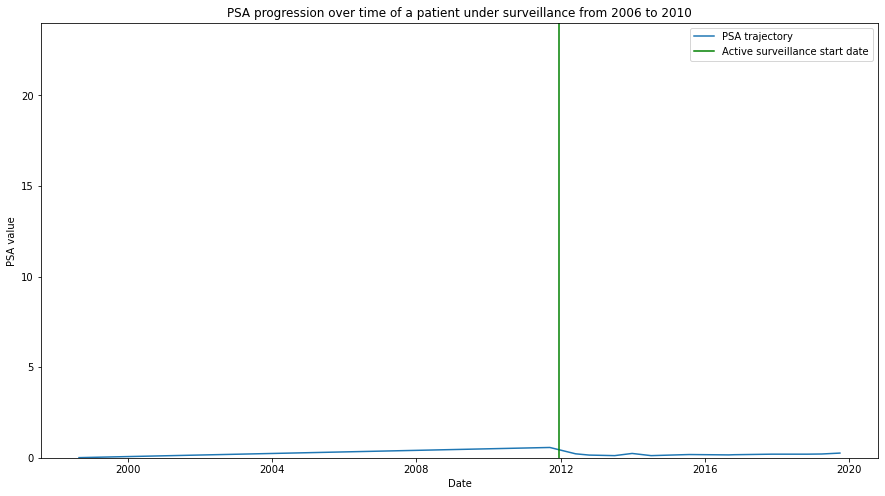

In [17]:
plt.figure(figsize=(15, 8))
example = merged[merged.EMPI == 111490209].sort_values("time_lab_result")
#example = merged[merged.EMPI == 100003030].sort_values("time_lab_result")
plt.plot(example.time_lab_result, example.PSA, label="PSA trajectory")
#plt.axvline(x=example.rdtdate_first.iloc[0], color="red", label="Radiation date")
plt.axvline(x=example.date_firstcancerbx.iloc[0], color="green", label="Active surveillance start date")
#plt.axvline(x=example.rdtdate_first.iloc[0], color="red", label="Radiation date")
plt.legend()
plt.xlabel("Date")
plt.ylabel("PSA value")
plt.title("PSA progression over time of a patient under surveillance from 2006 to 2010")
plt.ylim((0, 24))

In [19]:
merged_prior = merged[merged.time_lab_result < merged.date_firstcancerbx]
merged_after = merged[merged.time_lab_result >= merged.date_firstcancerbx]

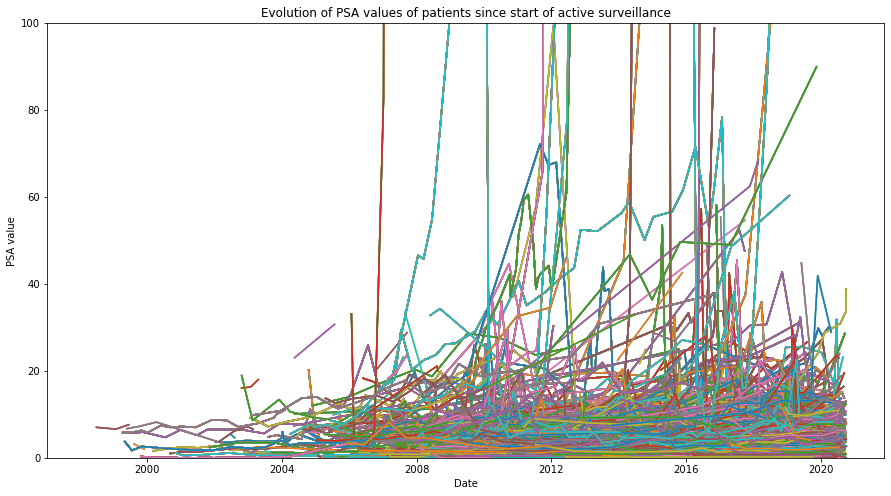

In [20]:
plt.figure(figsize=(15, 8))

for i in merged_after.EMPI:

    example = merged_after[merged_after.EMPI == i].sort_values("time_lab_result")
    plt.plot(example.time_lab_result, example.PSA, label=str(i))
    #plt.axvline(x=example.rdtdate_first.iloc[0], color="red", label="Radiation date")
    #plt.axvline(x=example.rdtdate_first.iloc[0], color="red", label="Radiation date")

plt.ylim((0, 100))
plt.xlabel("Date")
plt.ylabel("PSA value")
plt.title("Evolution of PSA values of patients since start of active surveillance")
plt.show()


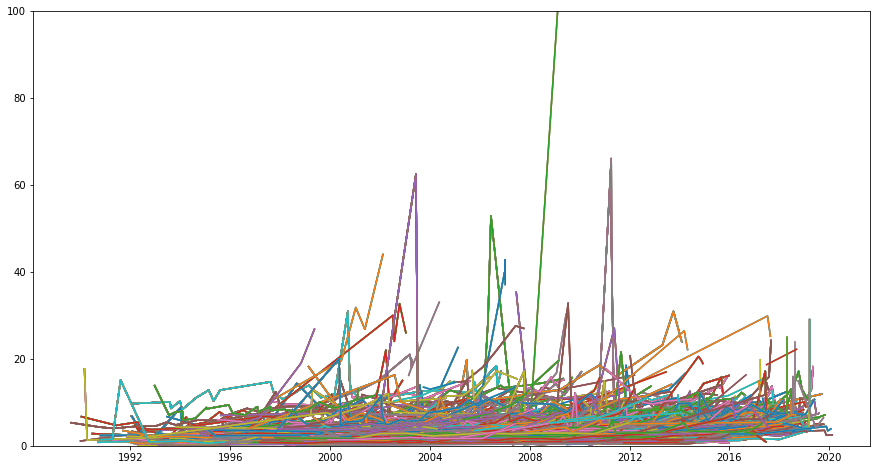

In [21]:
plt.figure(figsize=(15, 8))

for i in merged_prior.EMPI:

    example = merged_prior[merged_prior.EMPI == i].sort_values("time_lab_result")
    plt.plot(example.time_lab_result, example.PSA, label=str(i))
    #plt.axvline(x=example.rdtdate_first.iloc[0], color="red", label="Radiation date")
    #plt.axvline(x=example.rdtdate_first.iloc[0], color="red", label="Radiation date")

plt.ylim((0, 100))
plt.show()


Text(0.5, 1.0, 'Histogram of ages at diagnos')

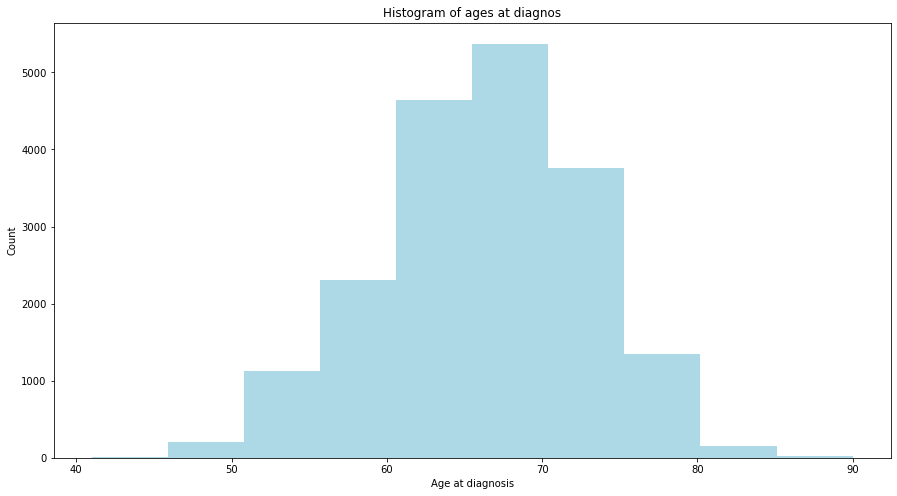

In [22]:
plt.figure(figsize=(15, 8))
plt.hist(merged.age_diagnosis, color="lightblue")
plt.xlabel("Age at diagnosis")
plt.ylabel("Count")
plt.title("Histogram of ages at diagnos")